In [1]:
import pandas as pd
import numpy as np
import dask.array as da
import dask.dataframe as dd
import time
import math
#import graphviz
from netCDF4 import Dataset
import os,datetime,sys,fnmatch
import h5py





In [2]:
def read_filelist(loc_dir,prefix,unie,fileformat):
    # Read the filelist in the specific directory
    str = os.popen("ls "+ loc_dir + prefix + unie + "*."+fileformat).read()
    fname = np.array(str.split("\n"))
    fname = np.delete(fname,len(fname)-1)
    
    return fname


def read_MODIS(fname1,fname2,verbose=False): # READ THE HDF FILE
    # Read the cloud mask from MYD06_L2 product')
    ncfile=Dataset(fname1,'r')
    CM1km = np.array(ncfile.variables['Cloud_Mask_1km'])
    CM   = (np.array(CM1km[:,:,0],dtype='byte') & 0b00000110) >>1
    #ncfile = Dataset(fname1, "r")
    #CM = myd06.variables["Cloud_Mask_1km"][:,:,:] # Reading Specific Variable 'Cloud_Mask_1km'.
    #CM   = (np.array(CM[:,:,0],dtype='byte') & 0b00000110) >>1
    ncfile.close()
    
    ncfile=Dataset(fname2,'r')
    lat  = np.array(ncfile.variables['Latitude'])
    lon  = np.array(ncfile.variables['Longitude'])
    #ncfile = Dataset(MOD03_files, "r")
    #latitude = myd03.variables["Latitude"][:,:] # Reading Specific Variable 'Latitude'.
    #latitude = np.array(latitude).byteswap().newbyteorder() # Addressing Byteswap For Big Endian Error.
    #longitude = myd03.variables["Longitude"][:,:] # Reading Specific Variable 'Longitude'.
    attr_lat = ncfile.variables['Latitude']._FillValue
    attr_lon = ncfile.variables['Longitude']._FillValue
    """#Use _FillValue to remove fill data in lat & lon
    lat[np.where(lat == attr_lat)] = 0.0
    lon[np.where(lat == attr_lat)] = 0.0
    CM [np.where(lat == attr_lat)] = 0.5 #which will not be identified by lines 80-83 
    lat[np.where(lon == attr_lon)] = 0.0
    lon[np.where(lon == attr_lon)] = 0.0
    CM [np.where(lon == attr_lon)] = 0.5 #which will not be identified by lines 80-83
    ncfile.close()"""
    return lat,lon,CM



In [3]:
def value_locate(refx, x):
    refx = np.array(refx)
    x = np.array(x)
    loc = np.zeros(len(x), dtype='int')
    
    for i in np.arange(len(x)):
        ix = x[i]
        ind = ((refx - ix) <= 0).nonzero()[0]
        if len(ind) == 0:
            loc[i] = -1
        else: loc[i] = ind[-1]

    return loc

def division(n, d):

    div = np.zeros(len(d))
    for i in range(len(d)):
        if d[i] >0:
          div[i]=n[i]/d[i]
        else: div[i]=None 

    return div

def countzero(x, axis=1):
    #print(x)
    count0 = 0
    count1 = 0
    for i in x:
        if i <= 1:
            count0 +=1
    #print(count0/len(x))
    return count0/len(x)

satellite = 'Aqua'

yr = [2008]
mn = [1] #np.arange(1,13)  #[1]
dy = [1] #np.arange(1,32) # [1] #np.arange(1,31)
lat_bnd = np.arange(-90,91,1)# latitude and longtitude boundaries of level-3 grid
lon_bnd = np.arange(-180,180,1)
nlat = 180
nlon = 360

TOT_pix      = np.zeros(nlat*nlon)
CLD_pix      = np.zeros(nlat*nlon)



In [195]:
MYD06_dir= '/Users/dprakas1/Desktop/modis_oneday/'
MYD06_prefix = 'MYD06_L2.A2008'
MYD03_dir= '/Users/dprakas1/Desktop/modis_oneday/'
MYD03_prefix = 'MYD03.A2008'
fileformat = 'hdf'

fname1,fname2 = [],[]


days = np.arange(1,31,dtype=np.int)
for day in days:
    dc ='%03i' % day
    fname_tmp1 = read_filelist(MYD06_dir,MYD06_prefix,dc,fileformat)
    fname_tmp2 = read_filelist(MYD03_dir,MYD03_prefix,dc,fileformat)
    fname1 = np.append(fname1,fname_tmp1)
    fname2 = np.append(fname2,fname_tmp2)

# Initiate the number of day and total cloud fraction
files  = np.arange(len(fname1))



for j in range(0,1):#hdfs:
    print('steps: ',j+1,'/ ',(fname1)) 

    # Read Level-2 MODIS data
    lat,lon,CM = read_MODIS(fname1[j],fname2[j])
print((fname1))
print((fname2))
#rint(CM)
#lat = lat.ravel()
#lon = lon.ravel()
#CM  = CM.ravel()
CM.shape    



cm = np.zeros((2030,1354), dtype=np.float32)

for MOD06_file in fname1:
    #print(MOD06_file)
    myd06 = Dataset(MOD06_file, "r")
    CM = myd06.variables["Cloud_Mask_1km"][:,:,0]# Reading Specific Variable 'Cloud_Mask_1km'.
    CM = (np.array(CM,dtype='byte') & 0b00000110) >>1
    CM = np.array(CM).byteswap().newbyteorder()
    #cm = da.from_array(CM, chunks =(2030,1354))
    #print(CM.shape)
    #cm = np.concatenate((cm,CM))
    cm = da.concatenate((cm,CM),axis=0)
    #bit0 = np.dstack((bit0,bit0r))
    #bit12 = np.dstack((bit12,bit12r))
    
print('The Cloud Mask Array Shape Is: ',cm.shape)


lat = np.zeros((2030,1354), dtype=np.float32)
lon = np.zeros((2030,1354), dtype=np.float32)
for MOD03_file in fname2:
    #print(MOD03_file)
    myd03 = Dataset(MOD03_file, "r")
    latitude = myd03.variables["Latitude"][:,:]# Reading Specific Variable 'Latitude'.
    #lat = da.from_array(latitude, chunks =(2030,1354))
    lat = da.concatenate((lat,latitude),axis=0)


    longitude = myd03.variables["Longitude"][:,:] # Reading Specific Variable 'Longitude'.
    #lon = da.from_array(longitude, chunks =(2030,1354))
    lon = da.concatenate((lon,longitude),axis=0)
    
print('Longitude Shape Is: ',lon.shape)
print('Latitude Shape Is: ',lat.shape)





steps:  1 /  ['/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0000.006.2013341193524.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0005.006.2013341193207.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0010.006.2013341192125.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0015.006.2013341193150.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0020.006.2013341193235.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0025.006.2013341192801.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0030.006.2013341193002.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0035.006.2013341193634.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0040.006.2013341200201.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0045.006.2013341200648.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0050.006.2013341205630.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A200

['/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0000.006.2013341193524.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0005.006.2013341193207.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0010.006.2013341192125.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0015.006.2013341193150.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0020.006.2013341193235.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0025.006.2013341192801.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0030.006.2013341193002.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0035.006.2013341193634.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0040.006.2013341200201.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0045.006.2013341200648.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0050.006.2013341205630.hdf'
 '/Users/dprakas1/Desktop/modis_oneday/MYD06_L2.A2008001.0055.006

The Cloud Mask Array Shape Is:  (586950, 1354)
Longitude Shape Is:  (586950, 1354)
Latitude Shape Is:  (586950, 1354)


In [196]:
type(cm)

dask.array.core.Array

In [197]:
lat

,Array,Chunk
Bytes,3.18 GB,11.05 MB
Shape,"(586950, 1354)","(2040, 1354)"
Count,42769 Tasks,289 Chunks
Type,float32,numpy.MaskedArray


In [198]:
cm=da.ravel(cm)
lat=da.ravel(lat)
lon=da.ravel(lon)



In [199]:
print(cm)
print(lat)

dask.array<reshape, shape=(794730300,), dtype=float32, chunksize=(2762160,)>
dask.array<reshape, shape=(794730300,), dtype=float32, chunksize=(2762160,)>


In [200]:
lon=lon.astype(int)
lat=lat.astype(int)
cm=cm.astype(int)



In [201]:
type(lat)

dask.array.core.Array

In [202]:
Lat=lat.to_dask_dataframe()
Lon=lon.to_dask_dataframe()
CM=cm.to_dask_dataframe()

In [47]:
df=dd.concat()

Dask Series Structure:
npartitions=2
0          int64
2748620      ...
5497239      ...
dtype: int64
Dask Name: from-dask, 11 tasks

In [46]:
df=dd.concat?

In [ ]:
df=dd.concat

In [203]:
df=dd.concat([Lat,Lon,CM],axis=1,interleave_partitions=False)

In [205]:
cols = {0:'Latitude',1:'Longitude',2:'CM'}
df = df.rename(columns=cols)
#df.compute()

In [206]:
df

,Latitude,Longitude,CM
npartitions=289,,,
0,int64,int64,int64
2748620,...,...,...
...,...,...,...
791981680,...,...,...
794730299,...,...,...


In [207]:
df2=df.groupby(['Longitude','Latitude']).CM.apply(countzero).reset_index()

/Users/dprakas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


In [208]:
type(df2)

dask.dataframe.core.DataFrame

In [209]:
df3=df2.compute()

In [210]:
df3

,Longitude,Latitude,CM
0,-177,44,1.000000
1,-173,-50,0.731746
2,-172,-5,0.592203
3,-171,-31,0.889730
4,-171,78,0.793747
5,-170,24,0.995998
6,-168,30,0.794235
7,-166,89,1.000000
8,-165,71,0.022523
9,-162,-52,0.873534


In [211]:
combs=[]
for x in range(-89,91):
    for y in range(-179,181):
        combs.append((x, y))

In [212]:
type(combs)

list

In [213]:
df_1=pd.DataFrame(combs)
df_1.columns=['Latitude','Longitude']
df_2=dd.from_pandas(df_1,npartitions=1)

#df_1=combs.to_frame()

In [214]:
type(df_1)

pandas.core.frame.DataFrame

In [215]:
#df4=df2.merge(df_1, how='outer',on=('Latitude','Longitude'))
df4=pd.merge(df_1, df3,on=('Longitude','Latitude'), how='left')

In [216]:
df4

,Latitude,Longitude,CM
0,-89,-179,0.864407
1,-89,-178,0.820922
2,-89,-177,0.843023
3,-89,-176,0.815299
4,-89,-175,0.833656
5,-89,-174,0.819066
6,-89,-173,0.794231
7,-89,-172,0.780622
8,-89,-171,0.800738
9,-89,-170,0.751402


In [217]:
df5=df4['CM'].values

b=df5.reshape(180,360)

#b=df4['CM'].to_dask_array(lengths=True).reshape([25,23])

In [218]:
total_cloud_fraction = b
out_name = '/Users/dprakas1/Desktop/dask_full.hdf5'
def save_hdf(out_name,total_cloud_fraction,lat_bnd,lon_bnd):
    f=h5py.File(out_name,'w')
    PCentry=f.create_dataset('CF',data=total_cloud_fraction)
    PCentry.dims[0].label='lat_bnd'
    #PCentry.dims[1].label='lon_bnd'

    PC=f.create_dataset('lat_bnd',data=lat_bnd)
    PC.attrs['units']='degrees'
    PC.attrs['long_name']='Latitude_boundaries'

    PC=f.create_dataset('lon_bnd',data=lon_bnd)
    PC.attrs['units']='degrees'
    PC.attrs['long_name']='Longitude_boundaries'
    f.close()
    print(out_name+' Saved!!')

save_hdf(out_name,total_cloud_fraction,lat_bnd,lon_bnd)




/Users/dprakas1/Desktop/dask_full.hdf5 Saved!!


Maximum absolute bias:0.0000
Minimum absolute bias:0.0000


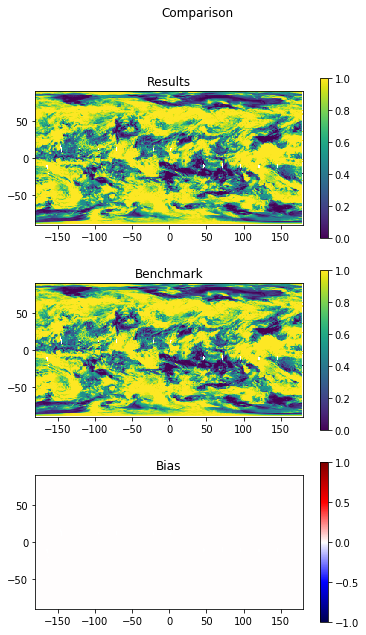

In [222]:
#for one day's data
import h5py
import numpy as np
from comparisons import readData, doPlot
#benchmark_p="/Users/dprakas1/Documents/"
#CF_BMK,_,_=readData(benchmark_p+"MODAgg_3var_parMonth_20080101.hdf5")#Benchmark

f=h5py.File('/Users/dprakas1/Desktop/dask_full.hdf5','r')
CF_res=f['CF'][:]
fig1,fig2=doPlot(CF_res,CF_res,'Comparison')

